# Plotting

Notebook dedicated to plotting the results of the explainer calculations

In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)




In [2]:
# Configurations

Settings=["Base", "Random", "Energy","Gamma"]
Model_types=["True", "Complex", "Simple"]
Param_array = [{'alpha' : 1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.0, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.0, 'delta' : 0.3, 'omega' : 0.0},
          {'alpha' : -1.0, 'beta' : -1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
          {'alpha' : 0.0, 'beta' : 0.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}]

In [3]:
i = 0
j = 1
k = 8

feature_setting = Settings[i]
model_setting = Model_types[j]
params = Param_array[k]

In [4]:
if feature_setting == "Base":
    from Code.BaseDuffing import Duffing
elif feature_setting == "Random":
    from Code.RandomDuffing import Duffing
elif feature_setting == "Energy":
    from Code.EnergyDuffing import Duffing
elif feature_setting == "Gamma":
    from Code.GammaDuffing import Duffing

In [5]:
# load dataset

duffing = Duffing(parameters = params)
eom = duffing.eom


features = duffing.features
labels = duffing.labels

In [17]:
big_df = pd.DataFrame()
for j in Model_types:
    suffix = feature_setting + "_" + model_setting + "_" + duffing.suffix
    temp_df = pd.read_csv("Results/ArrayRuns/Results/explainer_dataframe_"+suffix+".csv")
    temp_df.insert(0, "Model", [j for i in range(temp_df.shape[0])])
    big_df = big_df.append(temp_df)

In [18]:
big_df

,Model,Unnamed: 0,xt_x0,xt_v0,xt_t,vt_x0,vt_v0,vt_t,x0,v0,t,explainer
0,True,0,0.766072,0.226112,0.015838,-0.051067,0.004823,0.018307,0.974349,0.860495,0.979798,kernel
1,True,1,1.239510,-0.240178,0.008843,-0.052641,-0.000750,0.025800,0.981300,0.967124,0.898990,kernel
2,True,2,0.241540,0.730839,0.035533,-0.033284,0.013951,-0.008693,0.737782,0.049846,0.424242,kernel
3,True,3,0.010141,0.951825,0.046243,-0.014614,0.013300,-0.026603,0.371570,0.061192,0.828283,kernel
4,True,4,0.567192,0.443800,-0.002719,-0.027181,0.003678,-0.004450,0.836132,0.532018,0.717172,kernel
...,...,...,...,...,...,...,...,...,...,...,...,...
195,Simple,45,0.002563,0.000834,0.000000,-0.001483,-0.000432,0.000026,0.179448,0.025406,0.404040,numeric
196,Simple,46,0.000000,0.000000,0.000000,-0.000041,-0.000007,0.000000,0.877136,0.770379,0.484848,numeric
197,Simple,47,0.000596,-0.002146,0.000000,-0.001099,0.004213,-0.000004,0.522910,0.715185,0.444444,numeric
198,Simple,48,-3.736317,-0.569642,-64.163620,-4.688829,-1.558810,-7.888049,0.841832,0.651121,0.010101,numeric


In [19]:
# generate some data to train the scaler

end_time = 100
duffing.generate(100, samples = 100, end_time = end_time)
duffing.scale_features()

X = pd.DataFrame(duffing.scaler.inverse_transform(big_df[features]), columns = features)
y = pd.DataFrame(duffing.predict(big_df[features]), columns = labels)

Generating Data…: 100%|██████████████████| 100/100 [00:02<00:00, 45.44it/s]


In [20]:
# load model
suffix = feature_setting + "_" + "Simple" + "_" + duffing.suffix
model_simple = tf.keras.models.load_model("Models/ArrayRuns/Models/Model"+suffix)
simple_history = pickle.load(open('Models/ArrayRuns/Models/TrainingHistory/'+suffix, "rb"))

feature_setting + "_" + "Complex" + "_" + duffing.suffix
model_complex = tf.keras.models.load_model("Models/ArrayRuns/Models/Model"+suffix)
complex_history = pickle.load(open('Models/ArrayRuns/Models/TrainingHistory/'+suffix, "rb"))

model_true = duffing


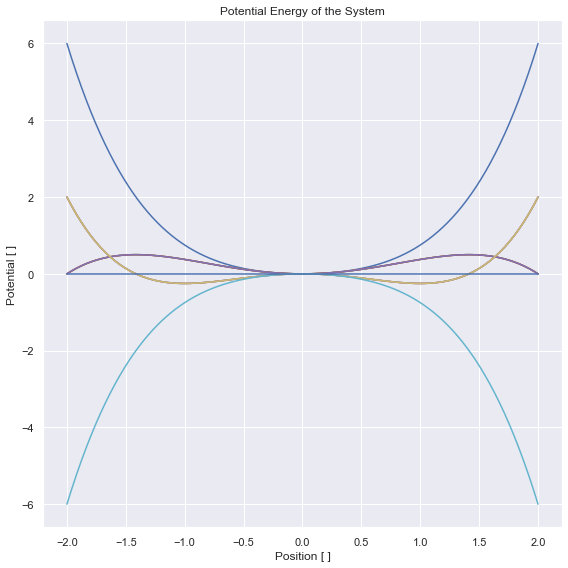

In [28]:
params_ = [{'alpha' : 1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
                  {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
                  {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : 1.0, 'beta' : -0.5, 'gamma' : 0.37, 'delta' : 0.0, 'omega' : 1.2},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2}, 
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.0, 'delta' : 0.3, 'omega' : 0.0},
                  {'alpha' : -1.0, 'beta' : -1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : 0.0, 'beta' : 0.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}]

f, axs = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw=dict(width_ratios=[4]))
for i in params_:
    x_potential = np.linspace(-2,2,100)

    v_potential = 0
    y_potential = (0.5*v_potential**2 + 0.5*i['alpha']*x_potential**2 +0.25*i['beta']*x_potential**4)



    sns.lineplot(x = x_potential, y=y_potential,ax=axs)
    
axs.set_xlabel('Position [ ]')
axs.set_ylabel('Potential [ ]')
axs.set_title("Potential Energy of the System")

f.tight_layout()

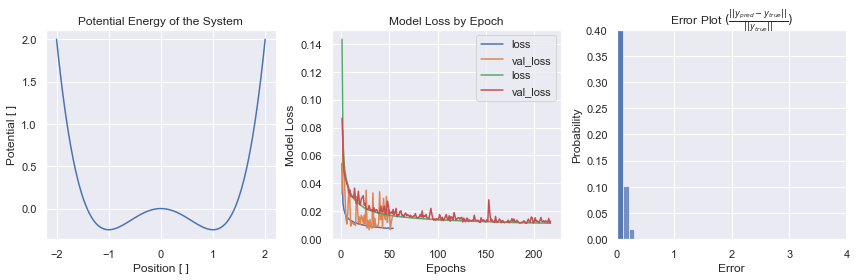

In [25]:
f, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4,4,4]))

x_potential = np.linspace(-2,2,100)

v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*params['alpha']*x_potential**2 +0.25*params['beta']*x_potential**4)



sns.lineplot(x = x_potential, y=y_potential,ax=axs[0])

axs[0].set_xlabel('Position [ ]')
axs[0].set_ylabel('Potential [ ]')
axs[0].set_title("Potential Energy of the System")

f.tight_layout()


for model_ in ["Complex", "Simple"]:
    suffix = feature_setting + "_" + model_ + "_" + duffing.suffix
    model = tf.keras.models.load_model("Models/ArrayRuns/Models/Model"+suffix)
    history = pickle.load(open('Models/ArrayRuns/Models/TrainingHistory/'+suffix, "rb"))
    # evaluate NN performance

    """
    Evaluate Model
    """

    # evaluate the fitting validation and training losses
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    ## Make Prdictions on the Test Dataset
    y_pred = pd.DataFrame(model.predict(big_df[features]), columns=['xt','vt'])

    pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
    true_norm = np.linalg.norm(y[['xt','vt']].values,axis=1)
    hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
    hist_data = pd.DataFrame(hist_data, columns=['norm'])

    def Remove_Outlier_Indices(df):
        Q1 = df.quantile(0.00)
        Q3 = df.quantile(0.95)
        IQR = Q3 - Q1
        trueList = ~((df > (Q3 + 1.5 * IQR)))
        #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
        return trueList

    indices = Remove_Outlier_Indices(hist_data)
    hist_data = hist_data[indices]
    # Model Loss and Error



    

    #f.savefig("Images/"+scenario+"/Potential_"+suffix+".svg", dpi='figure')



    sns.lineplot(data = history, x = epochs, y='loss',ax=axs[1], label='loss')
    sns.lineplot(data = history, x = epochs, y='val_loss',ax=axs[1], label='val_loss')

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Model Loss')
    axs[1].set_title("Model Loss by Epoch")
    axs[1].legend()


    # Error Plot for ML Predictions
    sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.1, ax=axs[2])

    axs[2].set(xlim=(0, 4), ylim=(0, 0.4))
    axs[2].set_xlabel('Error')
    axs[2].set_ylabel('Probability')
    axs[2].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")


    f.tight_layout()

    #f.savefig("Images/"+scenario+"/"+model_type+"Model/loss_"+suffix+".svg", dpi='figure')


In [57]:
duffing.X_df

,x0,v0,t,xt,vt
0,0.815212,0.742361,0.000000,1.224805,0.993039
1,0.815212,0.742361,0.010101,1.377123,-0.721313
2,0.815212,0.742361,0.020202,0.596972,-0.586227
3,0.815212,0.742361,0.030303,0.246428,-0.164462
4,0.815212,0.742361,0.040404,0.195992,0.046066
...,...,...,...,...,...
9995,0.592890,0.370073,0.959596,0.999997,0.000007
9996,0.592890,0.370073,0.969697,1.000004,0.000004
9997,0.592890,0.370073,0.979798,1.000004,-0.000006
9998,0.592890,0.370073,0.989899,0.999997,-0.000005


In [58]:
y_pred_true = duffing.predict(duffing.X_df[features])
y_pred_simple = model.predict(duffing.X_df[features])
y_pred_complex = model.predict(duffing.X_df[features])

In [59]:
y_pred_true = pd.DataFrame(y_pred_true, columns = duffing.labels)
y_pred_simple = pd.DataFrame(y_pred_simple, columns = duffing.labels)
y_pred_complex = pd.DataFrame(y_pred_complex, columns = duffing.labels)

In [70]:
plot_t = pd.DataFrame(duffing.scaler.inverse_transform(duffing.X_df[features]), columns = features)

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


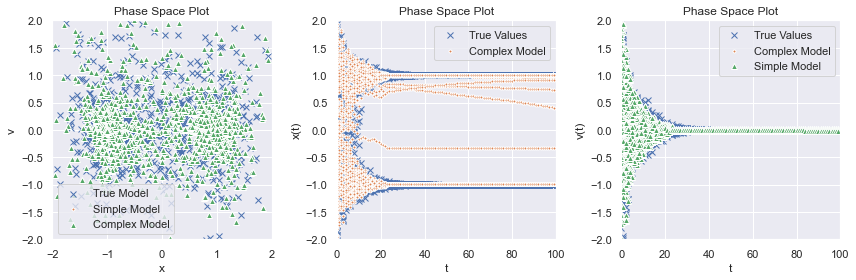

In [77]:
# Loss Plot ML Model
f, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4,4,4]))


# True Values Plot
sns.scatterplot(data = y_pred_true.iloc[:,:], x = 'xt', y='vt',ax=axs[0],label='True Model',
                marker='x', linewidth = 1)
# Simple Values Plot
sns.scatterplot(data = y_pred_simple.iloc[:,:], x='xt', y='vt',ax=axs[0],label='Simple Model',
                marker='.', linewidth = 1)
# Complex Values Plot
sns.scatterplot(data = y_pred_complex.iloc[:,:], x='xt', y='vt',ax=axs[0], label='Complex Model',
                marker='^', linewidth = 1)

axs[0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[0].set_xlabel('x')
axs[0].set_ylabel('v')
axs[0].set_title("Phase Space Plot")



# plots of x and v against time


# xt plot
# True Values Plot
sns.scatterplot(data = y_pred_true.iloc[:,:], x = plot_t['t'], y='xt',ax=axs[1],label='True Values',
                marker='x', linewidth = 1)
# Complex Values Plot
sns.scatterplot(data = y_pred_complex.iloc[:,:], x=plot_t['t'], y='xt',ax=axs[1],label='Complex Model',
                marker='.', linewidth = 1)
# Simple Values Plot
sns.scatterplot(data = y_pred_simple.iloc[:,:], x=plot_t['t'], y='xt',ax=axs[1],label='Simple Model',
                marker='^', linewidth = 1)

axs[1].set(xlim=(0, 100), ylim=(-2, 2))
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')
axs[1].set_title("Phase Space Plot")

# vt plot
# True Values Plot
sns.scatterplot(data = y_pred_true.iloc[:,:], x = plot_t['t'], y='vt',ax=axs[2],label='True Values',
                marker='x', linewidth = 1)
# Complex Values Plot
sns.scatterplot(data = y_pred_complex.iloc[:,:], x=plot_t['t'], y='vt',ax=axs[2],label='Complex Model',
                marker='.', linewidth = 1)
# Simple Values Plot
sns.scatterplot(data = y_pred_simple.iloc[:,:], x=plot_t['t'], y='vt',ax=axs[2],label='Simple Model',
                marker='^', linewidth = 1)

axs[2].set(xlim=(0, 100), ylim=(-2, 2))
axs[2].set_xlabel('t')
axs[2].set_ylabel('v(t)')
axs[2].set_title("Phase Space Plot")

f.tight_layout()

#f.savefig("Images/"+scenario+"/"+model_type+"Model/model_predictions_"+suffix+".svg", dpi='figure')

In [1]:
big_df = data_df.iloc[300:600,:]

NameError: name 'data_df' is not defined

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of 

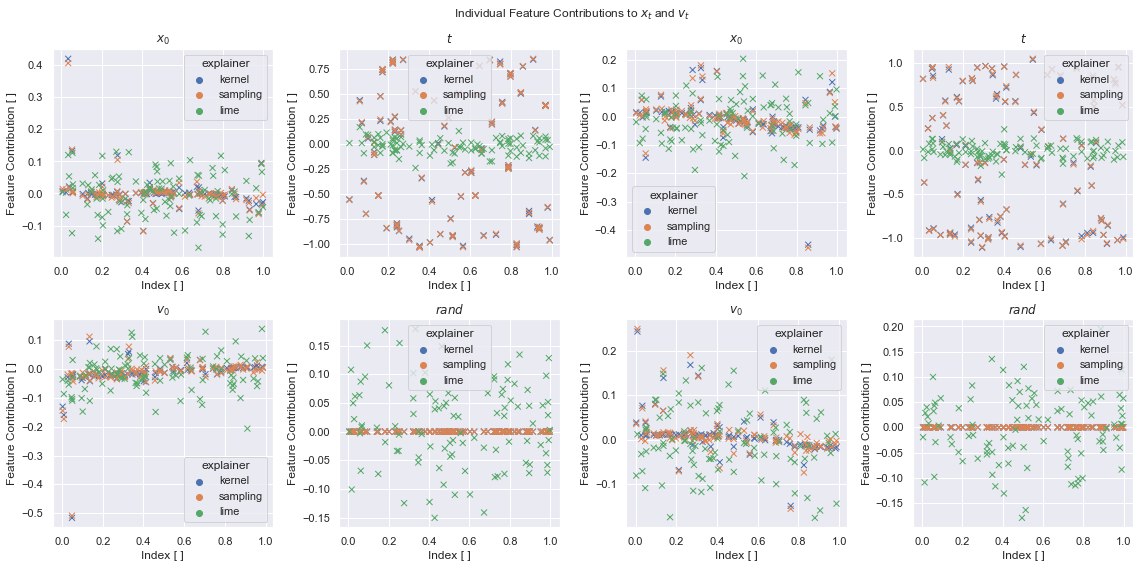

In [53]:
# individual feature attributions

# Individual Feature Contributions
f, axs = plt.subplots(2, 4, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4,4,4]))

sns.scatterplot(x='x0', y="xt_x0", data=big_df, ax=axs[0,0], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,0].set_title(r"$x_0$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="xt_v0", data=big_df, ax=axs[1,0], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,0].set_title(r"$v_0$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='t', y="xt_t", data=big_df, ax=axs[0,1], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,1].set_title(r"$t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="xt_rand", data=big_df, ax=axs[1,1], marker = 'x', linewidth = 1, hue = "explainer")

axs[1,1].set_title(r"$rand$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')


sns.scatterplot(x='x0', y="vt_x0", data=big_df, ax=axs[0,2], marker = 'x', linewidth = 1, hue = "explainer")

axs[0,2].set_title(r"$x_0$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_v0", data=big_df, ax=axs[1,2], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,2].set_title(r"$v_0$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='v0', y="vt_t", data=big_df, ax=axs[0,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[0,3].set_title(r"$t$")
axs[0,3].set_xlabel('Index [ ]')
axs[0,3].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(x='rand', y="vt_rand", data=big_df, ax=axs[1,3], marker = 'x', linewidth = 1, hue = "explainer")
axs[1,3].set_title(r"$rand$")
axs[1,3].set_xlabel('Index [ ]')
axs[1,3].set_ylabel('Feature Contribution [ ]')



f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$")

f.tight_layout()
f.savefig("Images/"+scenario+"/feature_importance_"+suffix+".svg", dpi='figure')

In [56]:
# Convert Data to Long Form to enable plotting with sns barplot

plot_cols = ['xt_x0', 'xt_v0', 'xt_t', 'xt_rand', 'vt_x0', 'vt_v0', 'vt_t', 'vt_rand', 'explainer']
agg_df = big_df[plot_cols].copy().set_index('explainer')
temp_df = pd.DataFrame()
agg_df_2 = pd.DataFrame()
for j, col in enumerate(agg_df.columns[:8]):
    for expl in agg_df.index.unique():
        temp_df['value'] = agg_df.loc[expl][col].values
        temp_df['feature'] = col
        temp_df['explainer'] = expl
        agg_df_2 = agg_df_2.append(temp_df)

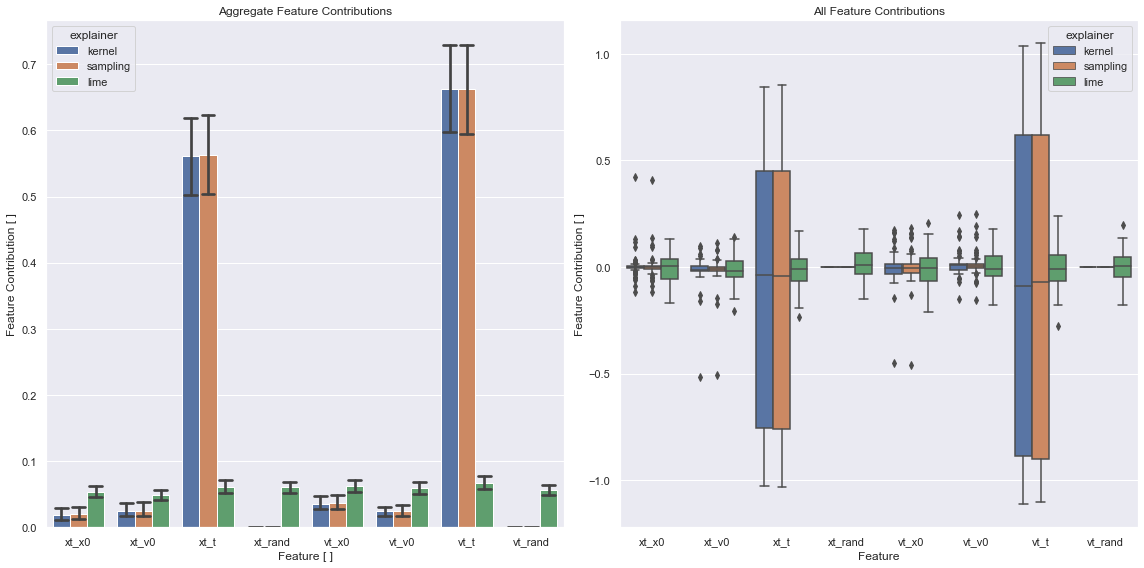

In [57]:
# aggregated feature importance

# Aggregated

f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


sns.barplot(data=agg_df_2, x = 'feature', y = np.abs(agg_df_2['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

axs[0].set_title(r"Aggregate Feature Contributions")
axs[0].set_xlabel('Feature [ ]')
axs[0].set_ylabel('Feature Contribution [ ]')

sns.boxplot(data=agg_df_2, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
axs[1].set_title(r"All Feature Contributions")
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Feature Contribution [ ]')


f.tight_layout()

f.savefig("Images/"+scenario+"/aggregated_feature_importance_"+suffix+".svg", dpi='figure')

In [ ]:
# numerical explainer convergence study

# choose random point from dataset
x_val = np.random.choice(choice, 1)



In [ ]:
class MyLime(shap.other.LimeTabular):
    def __init__(self, model, data, mode="classification"):
        self.model = model
        assert mode in ["classification", "regression"]
        self.mode = mode

        if str(type(data)).endswith("pandas.core.frame.DataFrame'>"):
            data = data.values
        self.data = data
        self.explainer = lime.lime_tabular.LimeTabularExplainer(data, mode=mode)
        self.out_dim = 1#self.model(data[0:1]).shape[1]
            
    def attributions(self, X, num_samples=500, num_features=None):
        try:
            num_features = X.shape[1] if num_features is None else num_features
        except:
            print('exception')
            num_features = 1
        if str(type(X)).endswith("pandas.core.frame.DataFrame'>"):
            X = X.values
            
        out = [np.zeros(X.shape) for j in range(len(self.model))]
        for i in tqdm(range(X.shape[0]), desc="Calculating Lime…", ascii=False, ncols=75):
            exp1 = self.explainer.explain_instance(X[i], self.model[0], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            exp2 = self.explainer.explain_instance(X[i], self.model[1], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            for k, v in exp1.local_exp[1]: 
                out[0][i,k] = v
            for k, v in exp2.local_exp[1]: 
                out[1][i,k] = v
          
        return out

In [ ]:
# lime convergence study
# use x_val from above



In [ ]:
    def __init__(self,
                 training_data,
                 mode="classification",
                 training_labels=None,
                 feature_names=None,
                 categorical_features=None,
                 categorical_names=None,
                 kernel_width=None,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 discretize_continuous=True,
                 discretizer='quartile',
                 sample_around_instance=False,
                 random_state=None,
                 training_data_stats=None):

In [96]:
#!/usr/bin/env python

import os

def mkdir_p(dir):
    '''make a directory (dir) if it doesn't exist'''
    if not os.path.exists(dir):
        os.mkdir(dir)
    

job_directory = "%s/.job" %os.getcwd()
#scratch = os.environ['SCRATCH']
#data_dir = os.path.join(scratch, '/project/ExplainabilityArray')

# Make top level directories
mkdir_p(job_directory)
#mkdir_p(data_dir)

Settings=["Base", "Random", "Energy","Gamma"]
Models=["True", "Complex", "Simple"]


lizards=["LizardA","LizardB"]

for Setting in Settings:
    for Model in Models:
        job_file=os.path.join(job_directory, Setting+Model+"s.job")
        #explainer_data = os.path.join(data_dir, Setting+Model)
        

    # Create lizard directories
    #mkdir_p(explainer_data)

    with open(job_file) as fh:
        fh.writelines("#!/bin/bash\n")
        fh.writelines("#SBATCH --partition=daily\n")
        fh.writelines("#SBATCH --time=23:30:00\n")
        fh.writelines("#SBATCH --clusters=merlin6\n")
        fh.writelines("#SBATCH --nodes=1\n")
        fh.writelines("#SBATCH --ntasks=1\n")
        fh.writelines("#SBATCH --ntasks-per-node=1\n")
        fh.writelines("#SBATCH --cpus-per-task=1\n")
        fh.writelines("#SBATCH --#SBATCH --output=/data/user/grosche_w/XAI/XAI/FinalRuns/Logs/"+Setting+Params+"_out_%j.log\n")
        fh.writelines("#SBATCH --job-name="+{Setting}+{Params}+"_run\n")
        fh.writelines("""NOW=$(date +"%m-%d-%Y")\n""")
        fh.writelines("""echo "Starting time: $NOW, $NOW2"\n""")
        fh.writelines("""echo ""\n""")
        fh.writelines("""START=$(date +%s)\n""")
        fh.writelines("""module use unstable\n""")
        fh.writelines("""module load anaconda\n""")
        fh.writelines("""conda activate /data/user/grosche_w/myenv\n""")
        fh.writelines("python3 "+Setting+"Feature.py\n")
        fh.writelines("""END=$(date +%s)\n""")
        fh.writelines("""DIFF=$(( $END - $START ))\n""")
        fh.writelines("""echo "It took $DIFF seconds"\n""")
        fh.writelines("""NOW=$(date +"%m-%d-%Y")\n""")
        fh.writelines("""NOW2=$(date +"%r")""")
        fh.writelines("""echo "Ending time: $NOW, $NOW2"\n""")
        fh.writelines("""echo """"")
       
   

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Polybox\\SyncFolder\\XAI\\Plotting/.job\\BaseSimples.job'